#For training

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install zipfile36
!pip install git+https://github.com/mr7495/RetinaNet

  Cloning https://github.com/mr7495/RetinaNet to /tmp/pip-req-build-u6n_r7kv
  Running command git clone -q https://github.com/mr7495/RetinaNet /tmp/pip-req-build-u6n_r7kv
  Running command git submodule update --init --recursive -q
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp37-cp37m-linux_x86_64.whl size=181942 sha256=5ab4bf6bc4b5b9dfb71fa88ecc39c63a2baa91261b34b57c3fb984ad93ff7b5d
  Stored in directory: /tmp/pip-ephem-wheel-cache-nuphyo05/wheels/08/6d/f5/38473102b36a5975e02e8f339fbf85bc4d1b1c7c80dc68a595
  Created wheel for keras-resnet: filename=keras_resnet-0.1.0-py2.py3-none-any.whl size=13346 sha256=ab8f35b3ba804ed613cc3391601df60a2b8382480d45fc6bf120d360c1dfd1e8
  Stored in directory: /root/.cache/pip/wheels/80/dd/ac/842235b63dddac12faa4b48ebe58b8944e8c2e57c2e38dddb6
Successfully built keras-retinanet keras-resnet


In [ ]:
import keras
import numpy as np
import cv2
import os
import random
import shutil
import pandas as pd
import csv
import zipfile
from keras import optimizers
from keras.models import Sequential,Model
from keras.layers import Dropout, Flatten, Dense,Input
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint
from keras.applications.imagenet_utils import preprocess_input
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import RandomNormal
import keras.backend as k
from sklearn.utils import shuffle
import io
from PIL import Image as pil_image
from keras_retinanet import layers
import keras.backend as k
import keras_retinanet

In [ ]:
archive = zipfile.ZipFile('/content/drive/MyDrive/Train&Validation.zip') 
for file in archive.namelist():
     archive.extract(file, './data') #extract all image to folder data for training

In [ ]:
#image data preprocessing
fold_num = 4
train_datagen = ImageDataGenerator(horizontal_flip = True, vertical_flip = True, zoom_range = 0.05, rotation_range = 360, width_shift_range = 0.05, height_shift_range = 0.05, shear_range = 0.05)
test_datagen = ImageDataGenerator()
train_df = pd.read_csv('/content/drive/MyDrive/CSV/train{}.csv'.format(fold_num)) #read train csv file
validation_df = pd.read_csv('/content/drive/MyDrive/CSV/validation{}.csv'.format(fold_num)) #read validation csv file (Validation in the training process)
train_df = shuffle(train_df) #shuffle the train data
test_df = pd.read_csv('/content/drive/MyDrive/CSV/test{}.csv'.format(fold_num)) #read test csv file (For evaluating the final version of the trained network)

In [ ]:
shape = (512, 512, 1) #shape of the dataset images (in TIFF format)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(dataframe = train_df, directory='data', x_col = "filename", y_col = "class", target_size = (512, 512), batch_size = 14,
                                                    class_mode = 'categorical', color_mode = "grayscale", shuffle = True)
validation_generator = test_datagen.flow_from_dataframe(dataframe = validation_df, directory = 'data', x_col = "filename", y_col = "class", target_size = (512, 512), batch_size = 10,
                                                        class_mode = 'categorical', color_mode = "grayscale", shuffle=True)
test_generator = test_datagen.flow_from_dataframe(dataframe = test_df, directory = 'data', x_col = "filename", y_col = "class", target_size = (512, 512), batch_size = 10,
                                                  class_mode = 'categorical', color_mode = "grayscale", shuffle = True)

Found 3743 validated image filenames belonging to 2 classes.
Found 909 validated image filenames belonging to 2 classes.
Found 8315 validated image filenames belonging to 2 classes.


In [ ]:
input_tensor = Input(shape=shape)
weight_model = ResNet50(weights='imagenet', include_top=False) #load ResNet50V2 ImageNet pre-trained weights
weight_model.save_weights('weights.h5') #save the weights
base_model = ResNet50(weights=None, include_top=False, input_tensor=input_tensor) #load the ResNet50V2 model without weights
base_model.load_weights('weights.h5',skip_mismatch=True, by_name=True) #load the ImageNet weights on the ResNet50V2 model except the first layer(because the first layer has one channel in our case)

In [ ]:
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D

x = Sequential()
x = GlobalAveragePooling2D(name='avg_pool')(base_model.output)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='sigmoid', name='output')(x)
model = Model(inputs=base_model.inputs, outputs=x)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
'''
top_num = 4
for layer in model.layers[:-top_num]:
    layer.trainable = False

for layer in model.layers[-top_num:]:
    layer.trainable = True
'''
for layer in model.layers:
  layer.trainable = True

In [ ]:
from tensorflow.python.keras.callbacks import EarlyStopping

k.clear_session() #clear keras backend 
try:
  os.mkdir('models') #create folder for saving the model
except:
  pass
full_name = 'ResNet50-fold{}'.format(fold_num)
classes_number = 2 #normal and COVID-19
#sgd = SGD(lr = 1e-3, decay = 1e-6, momentum = 0.9, nesterov = True)
#model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.compile(optimizer=optimizers.Nadam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
filepath = "models/%s-{epoch:02d}-{val_accuracy:.4f}.hdf5"%full_name #path to save the model
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max') #save the best validation accuracy
early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)
model.fit(train_generator, epochs=20, validation_data=validation_generator, shuffle=True, callbacks=[checkpoint, early_stopper]) 

Epoch 1/20
268/268 [==============================] - 576s 2s/step - loss: 0.4256 - accuracy: 0.7900 - val_loss: 0.3198 - val_accuracy: 0.9010
Epoch 2/20
268/268 [==============================] - 549s 2s/step - loss: 0.1300 - accuracy: 0.9571 - val_loss: 0.4089 - val_accuracy: 0.9054
Epoch 3/20
268/268 [==============================] - 549s 2s/step - loss: 0.1099 - accuracy: 0.9618 - val_loss: 0.9880 - val_accuracy: 0.7558
Epoch 4/20
268/268 [==============================] - 549s 2s/step - loss: 0.0965 - accuracy: 0.9703 - val_loss: 0.1821 - val_accuracy: 0.9659
Epoch 5/20
268/268 [==============================] - 549s 2s/step - loss: 0.0642 - accuracy: 0.9780 - val_loss: 0.5474 - val_accuracy: 0.7767
Epoch 6/20
268/268 [==============================] - 549s 2s/step - loss: 0.1094 - accuracy: 0.9636 - val_loss: 0.2629 - val_accuracy: 0.9285
Epoch 7/20
268/268 [==============================] - 549s 2s/step - loss: 0.0674 - accuracy: 0.9753 - val_loss: 0.4083 - val_accuracy: 0.8658

In [ ]:
!cp /content/models/ResNet50-fold4-04-0.9659.hdf5 /content/drive/MyDrive/backup_models/ResNet50_Fold4

In [ ]:
!rm -rf /content/models

#For testing

In [ ]:
import keras
import numpy as np
import cv2
import os
import random
import shutil
import pandas as pd
import csv
import zipfile
from keras import optimizers
from keras.models import Sequential,Model
from keras.layers import Dropout, Flatten, Dense,Input
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint
from keras.applications.imagenet_utils import preprocess_input
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import RandomNormal
import keras.backend as k
from sklearn.utils import shuffle
import io
from PIL import Image as pil_image
import keras.backend as k

In [ ]:
archive = zipfile.ZipFile('/content/drive/MyDrive/COVID-CTset.zip') 
for file in archive.namelist():
     archive.extract(file, './test_data') #Extract the data for testing

In [ ]:
shape=(512,512,1) #shape of the dataset images (in TIFF format)

In [ ]:
#Run the CT selection Algorithm
def perpare_input(data_path_):
    !mkdir 'selected_data'
    data_path= data_path_ #path to the folder that contained the patient CT scans images
    data_files=[]
    for r,d,f in os.walk(data_path): #add the path of the CT scan images of the patient
        for file in f:
            if '.tif' in file:
                data_files.append(os.path.join(r,file)) #get the images path from the data_folder

    selected=[]          
    zero=[]
    names=[]
    for img_path in data_files:
        names.append(img_path)
        pixel=cv2.imread(img_path,cv2.IMREAD_UNCHANGED ) #read the TIFF file
        sp=pixel[240:340,120:370] #Crop the region
        counted_zero=0
        for i in np.reshape(sp,(sp.shape[0]*sp.shape[1],1)):
            if i<300: #count the number of pixel values in the region less than 300
                counted_zero+=1
        zero.append(counted_zero) #add the number of dark pixels of the image to the list
    min_zero=min(zero)
    max_zero=max(zero)
    threshold=(max_zero-min_zero)/1.5 #Set the threshold
    indices=np.where(np.array(zero)>threshold) #Find the images that have more dark pixels in the region than the calculated threshold
    selected_names=np.array(names)[indices] #Selected images

    for selected_img in selected_names:
        shutil.copy(selected_img,'selected_data')

In [ ]:
#The fully automated patient classification network
def classify(model_path):
    Path= model_path #Path to the trained models' # You can use this trained model : 'drive/My Drive/COVID-CTset/trained_networks/FPN-fold1.hdf5'
    selected_imgs_path=[]
    for r,d,f in os.walk('selected_data'): # add the path of the selected images
        for file in f:
            if '.tif' in file:
                selected_imgs_path.append(os.path.join(r,file)) #get the images path from the data_folder

    k.clear_session() #clear keras backend
    ###
    custom_object={'UpsampleLike': keras_retinanet.layers._misc.UpsampleLike} #Upsampling layer that was used in feature pyramid network
    net=keras.models.load_model(Path, custom_objects=custom_object)
    ###
    #net = keras.models.load_model(Path)

    covid_label=0 # index of COViD-19 class 
    normal_label=1  # index of normal class 
    normal_predicted=0
    covid_predicted=0
    for img_name in selected_imgs_path: #read images
        img=cv2.imread(img_name,cv2.IMREAD_UNCHANGED)
        pred_ind=np.argmax(net.predict(np.expand_dims(np.expand_dims(img,axis=0),axis=3))[0]) #predicted label
        if pred_ind==normal_label:
            normal_predicted+=1
        else:
            covid_predicted+=1

    all_imgs_num=len(selected_imgs_path) 
    if covid_predicted>=0.1*all_imgs_num: #if at lealassified as covidst 10% of a patient CT scans be c
        print('The patient is identified as infected to COVID-19')
    else:
        print('The patient is identified as normal')

In [ ]:
'''
perpare_input('/content/test_data/COVID-CTset/normal1/patient146/SR_2')
classify('/content/models/VGG16-fold1-01-0.6151.hdf5')
!rm -rf /content/selected_data
'''

The patient is identified as normal


In [ ]:
from pathlib import Path

cnt = 0
for i in range(146, 151):
  path_test = Path('/content/test_data/COVID-CTset/normal1/patient' + str(i) + '/SR_2')
  if path_test.is_dir():
    cnt += 1
    print('Test patient ' + str(i))
    print('cnt ' + str(cnt))
    perpare_input('/content/test_data/COVID-CTset/normal1/patient' + str(i) + '/SR_2')
    classify('/content/drive/MyDrive/backup_models/ResNet50V2_FPN_Fold1/ResNet50V2-FPN-fold1-03-0.9649.hdf5')
    !rm -rf /content/selected_data

Test patient 146
cnt 1
The patient is identified as infected to COVID-19
Test patient 147
cnt 2
The patient is identified as normal
Test patient 148
cnt 3
The patient is identified as normal
Test patient 149
cnt 4
The patient is identified as normal
Test patient 150
cnt 5
The patient is identified as normal


In [ ]:
!cp -a /content/models /content/drive/MyDrive/backup_models

#Test with 1 patient

In [ ]:
import matplotlib.pyplot as plt
#10, 5
def ceildiv(a, b):
    return -(-a // b)
def plots_from_files(imspaths, figsize=(50, 50), rows=1, titles=None, maintitle=None):
    """Plot the images in a grid"""
    f = plt.figure(figsize=figsize)
    if maintitle is not None:
        plt.suptitle(maintitle, fontsize=10)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i + 1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspaths[i])
        plt.imshow(img, cmap=plt.cm.gist_gray)

The patient is identified as infected to COVID-19


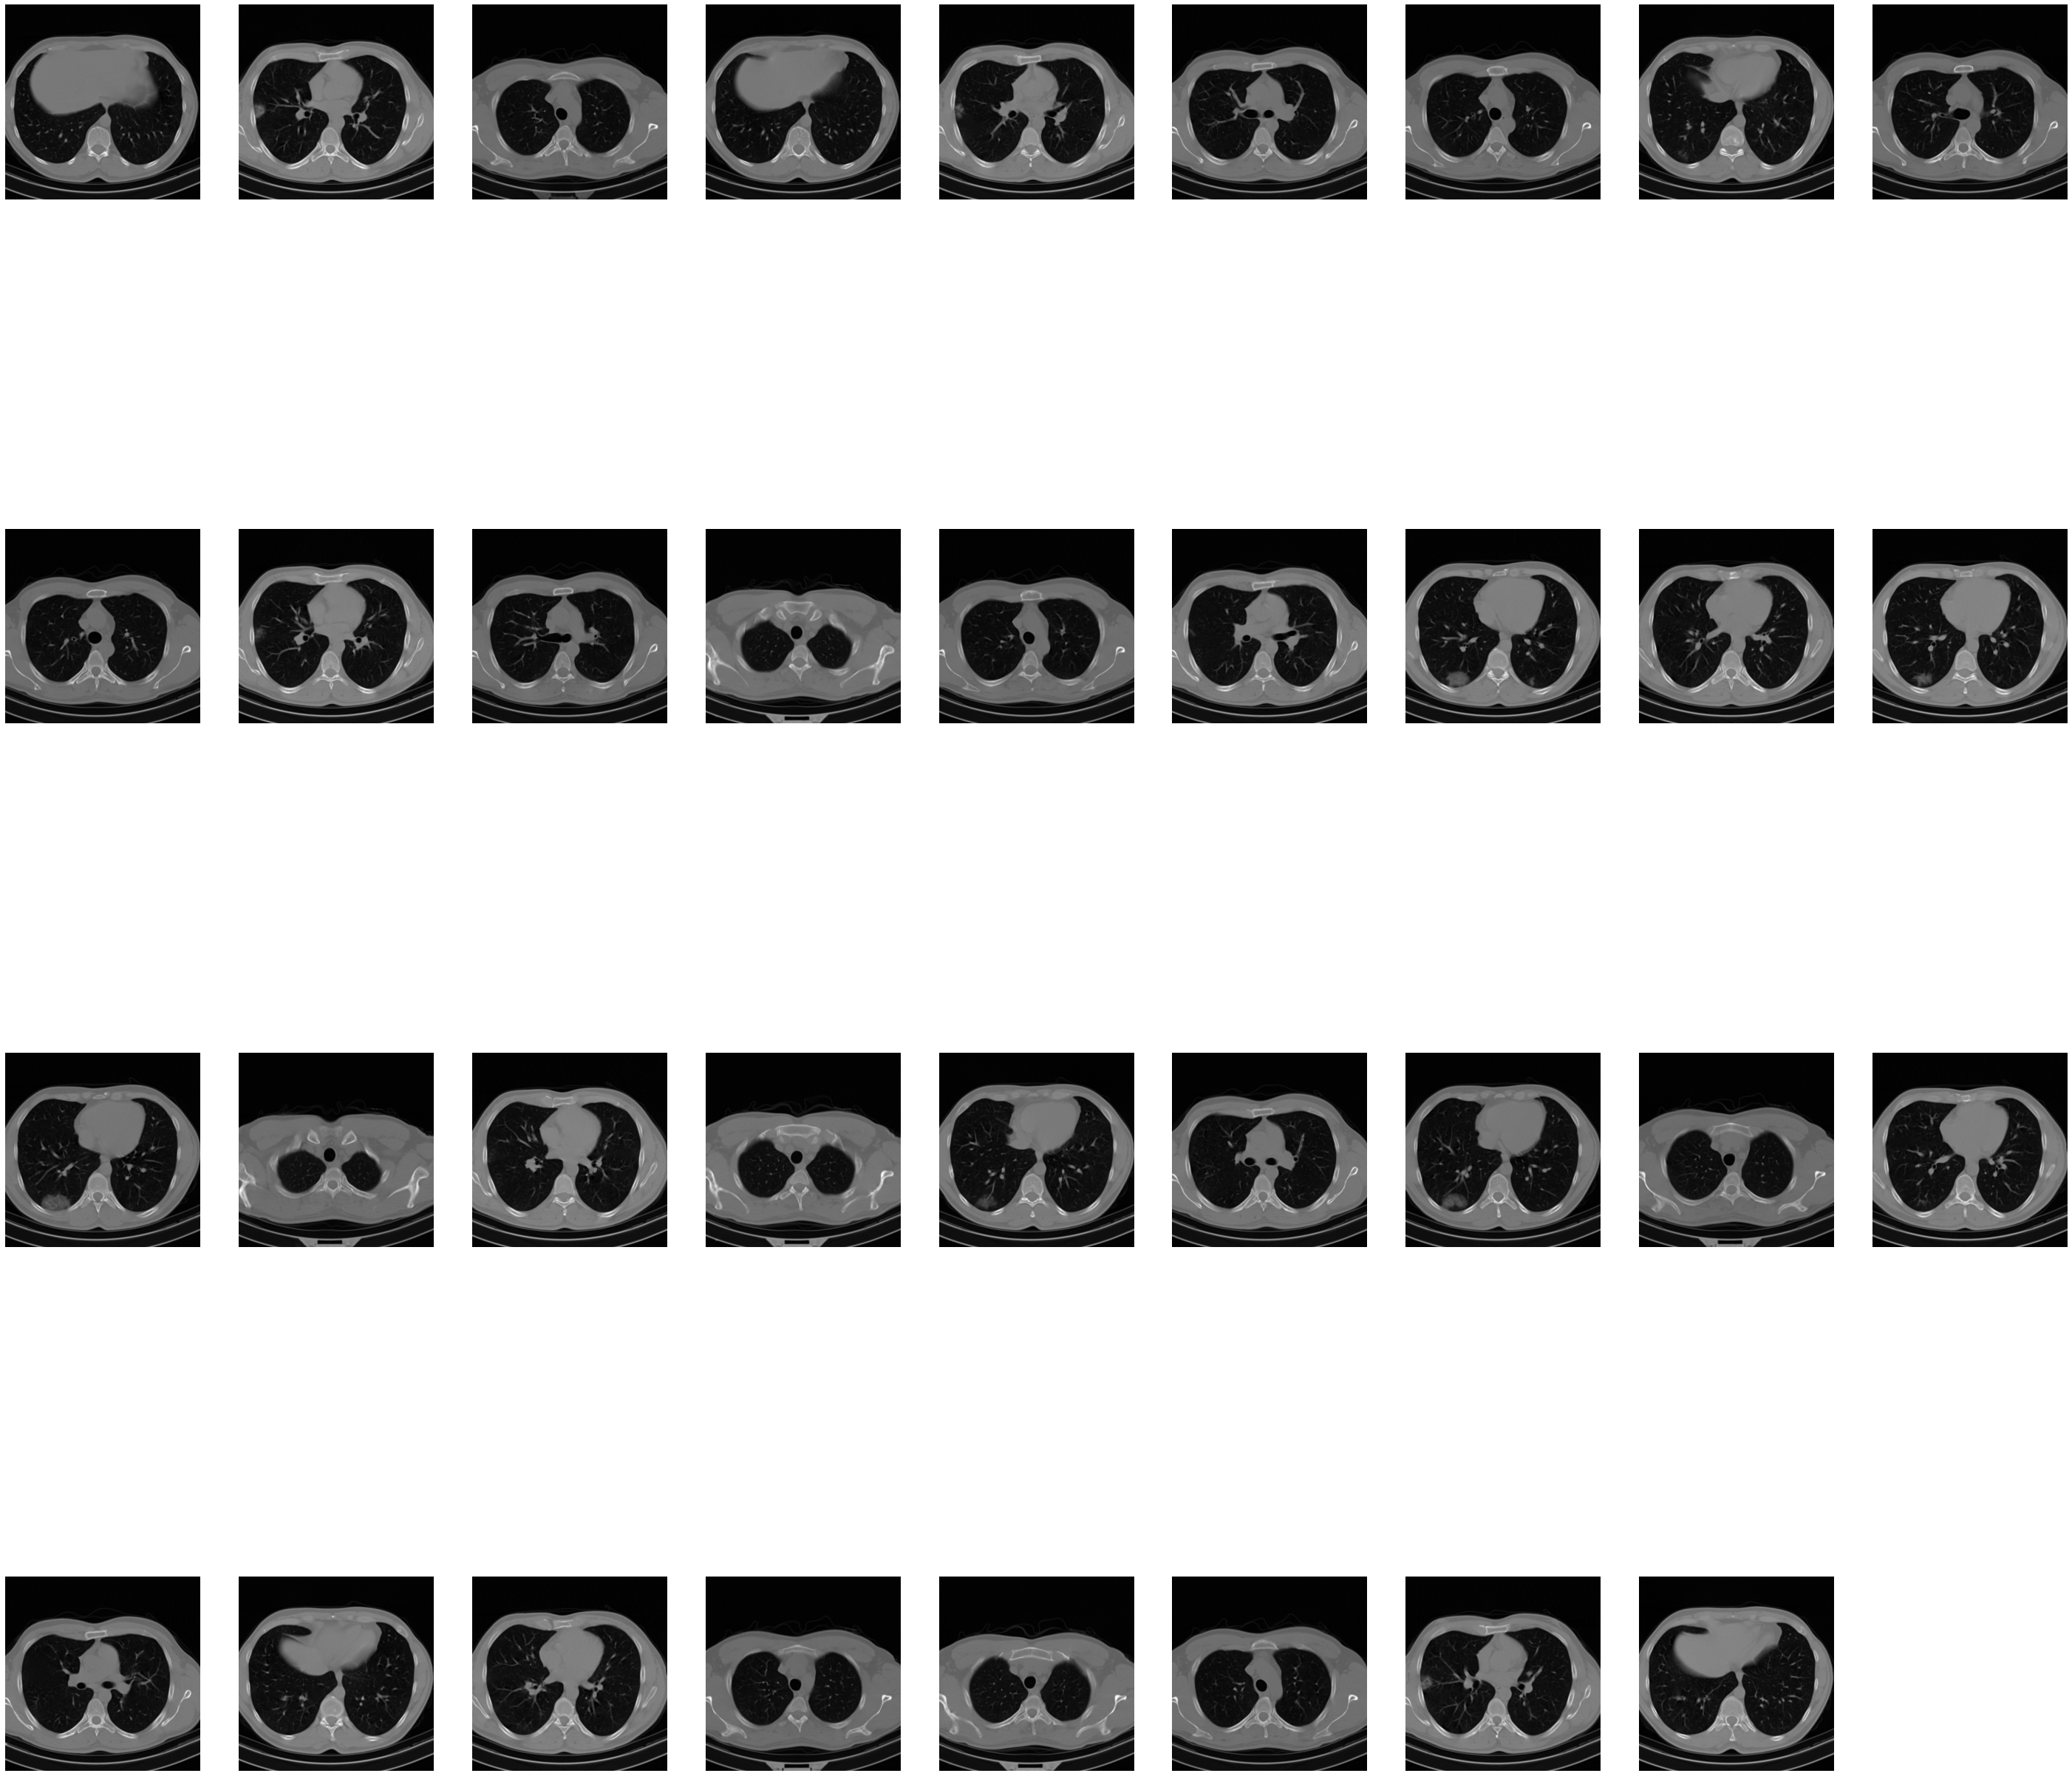

In [ ]:
perpare_input("/content/test_data/COVID-CTset/covid2/patient142/SR_2")
classify("/content/drive/MyDrive/backup_models/ResNet50V2_FPN_Fold3/ResNet50V2-FPN-fold3-07-0.9866.hdf5")

for r,d,f in os.walk('selected_data'): # add the path of the selected images
    my_img_paths = []
    for file in f:
        if '.tif' in file:
            my_img_paths.append("/content/selected_data/" + file)
    plots_from_files(my_img_paths, rows=4, maintitle=None)
    !rm -rf /content/selected_data